Liz's Results are in http://crick.bio.uci.edu/erebboah/postnatal_splitseq/adrenal/ENCSR193PLQ/ I should use the unfiltered?

In [1]:
import csv
from collections import Counter
import scanpy
import pysam
from pathlib import Path
import pandas
import requests
import numpy
import os
import re
import shutil
import scipy
import gzip
import sys
from matplotlib import pyplot
import matplotlib
import upsetplot
import warnings
from urllib.parse import urljoin
import yaml

In [2]:
EC = str(Path("~/proj/encoded_client").expanduser())
if EC not in sys.path:
    sys.path.append(EC)
from encoded_client import ENCODED

In [3]:
MEX = str(Path("~/proj/mex_gene_archive").expanduser())
if MEX not in sys.path:
    sys.path.append(MEX)
from mex_gene_archive.filter import write_filtered_mtx
from mex_gene_archive.splitseq import archive_split_seq_solo
from mex_gene_archive.starsolo import archive_star_solo
from mex_gene_archive.reader import read_mex_archive_as_anndata

In [4]:
WRS = str(Path("~/proj/woldlab-rna-seq").expanduser())
if WRS not in sys.path:
    sys.path.append(WRS)
from woldrnaseq.plots.scrna_matrix_qc import (
    calculate_qc,
    generate_violin_plot,
    make_pct_mt_scatter,
    make_gene_by_count_scatter,
)

In [5]:
from common import scanpy_load_solo_mtx

In [6]:
%matplotlib inline

In [7]:
star_analysis_dir = Path("adrenal/mouse_adr_2k_a18m_m1_pipeline")
erebboah_base = "http://crick.bio.uci.edu/erebboah/postnatal_splitseq/adrenal/A_18m_M_1/"
erebboah_unfiltered = erebboah_base + "DGE_unfiltered/"
erebboah_filtered = erebboah_base + "DGE_filtered/"


In [8]:
gene_id_name_map = {}
genome_dir = Path("~/proj/genome/mm10-M21-male-2.7.9a").expanduser()
with open(genome_dir / "geneInfo.tab", "rt") as instream:
    count = instream.readline()
    for line in instream:
        gene_id, gene_name, gene_type = line.rstrip().split("\t")
        if gene_name == "NULL":
            gene_name = gene_id
        gene_id_name_map[gene_id] = gene_name
        


In [9]:
myrun = read_mex_archive_as_anndata(star_analysis_dir / "GeneFull_Ex50pAS_Unique_filtered.tar.gz")
calculate_qc(myrun, gene_id_name_map)

print("count sum", myrun.X.sum().sum())
print("shape", myrun.shape)

count sum 166927.0
shape (448, 81881)


In [10]:
myrunem = read_mex_archive_as_anndata(star_analysis_dir / "GeneFull_Ex50pAS_EM_filtered.tar.gz")
calculate_qc(myrunem, gene_id_name_map)

print("count sum", myrunem.X.sum().sum())
print("shape", myrunem.shape)

count sum 172623.0
shape (448, 81881)


In [11]:
myrun_raw = read_mex_archive_as_anndata(star_analysis_dir / "GeneFull_Ex50pAS_Unique_raw.tar.gz")
calculate_qc(myrun_raw, gene_id_name_map)

print("count sum", myrun_raw.X.sum().sum())
print("shape", myrun_raw.shape)

count sum 327967.0
shape (442368, 81881)


In [12]:
myrun_raw[myrun_raw.obs["total_counts"] > 0].obs_names

Index(['AACCGAGAAAACATCG_11', 'AAGGACACAAACATCG_11', 'AATCCGTCAAACATCG_11',
       'ACACAGAAAAACATCG_11', 'ACCACTGTAAACATCG_11', 'ACGTATCAAAACATCG_11',
       'ACTATGCAAAACATCG_11', 'CACTTCGAAAACATCG_11', 'CAGATCTGAAACATCG_11',
       'CAGCGTTAAAACATCG_11',
       ...
       'CACTTCGATTCACGCA_23', 'CAGATCTGTTCACGCA_23', 'CCAGTTCATTCACGCA_23',
       'CCATCCTCTTCACGCA_23', 'CCTCTATCTTCACGCA_23', 'CGACTGGATTCACGCA_23',
       'CTAAGGTCTTCACGCA_23', 'GACAGTGCTTCACGCA_23', 'GAGTTAGCTTCACGCA_23',
       'TCTTCACATTCACGCA_23'],
      dtype='object', length=5452)

In [13]:
myrunem_raw = read_mex_archive_as_anndata(star_analysis_dir / "GeneFull_Ex50pAS_EM_raw.tar.gz")
calculate_qc(myrunem_raw, gene_id_name_map)

print("count sum", myrunem_raw.X.sum().sum())
print("shape", myrunem_raw.shape)

count sum 338363.0
shape (442368, 81881)


In [14]:
req = requests.get(urljoin(erebboah_filtered, "DGE.mtx"), stream=True)
uci_dge_filtered = scipy.io.mmread(req.raw)

ucirun_filtered = scanpy.AnnData(uci_dge_filtered.tocsr())

print("uci count sum", ucirun_filtered.X.sum().sum())
print("uci", ucirun_filtered)

uci count sum 83712.0
uci AnnData object with n_obs × n_vars = 20 × 6009


In [15]:
req = requests.get(urljoin(erebboah_unfiltered, "DGE.mtx"), stream=True)
uci_dge = scipy.io.mmread(req.raw)

ucirun = scanpy.AnnData(uci_dge.tocsr())

print("uci count sum", ucirun.X.sum().sum())
print("uci", ucirun)

uci count sum 338505.0
uci AnnData object with n_obs × n_vars = 5442 × 13332


In [16]:
cell_metadata = pandas.read_csv(urljoin(erebboah_unfiltered, "cell_metadata.csv"), index_col=0)
ucirun.obs_names = cell_metadata["cell_barcode"]
cell_metadata.head()

,cell_barcode,species,sample,rnd1_well,rnd2_well,rnd3_well,umi_count,umi_count_50dup,gene_count
0,ATCATTCCATAGCGAC_11,mm10,A_18m_M_1,11,79,80,15311,10721.363972,4364
1,TGGCTTCATCTTCACA_23,mm10,A_18m_M_1,23,62,65,15256,10682.850810,4397
2,TGGCTTCAGAACAGGC_11,mm10,A_18m_M_1,11,91,65,7645,5353.329473,3041
3,CACCTTACGCTCGGTA_23,mm10,A_18m_M_1,23,52,83,7027,4920.581584,2813
4,GGTGCGAAAGCCATGC_11,mm10,A_18m_M_1,11,77,54,5973,4182.529358,2704


In [17]:
genes = pandas.read_csv(urljoin(erebboah_unfiltered, "genes.csv"), index_col=0)
genes

,gene_id,gene_name,genome
0,ENSMUSG00000000001.4,Gnai3,mm10
1,ENSMUSG00000000031.16,H19,mm10
2,ENSMUSG00000000049.11,Apoh,mm10
3,ENSMUSG00000000056.7,Narf,mm10
4,ENSMUSG00000000058.6,Cav2,mm10
...,...,...,...
13327,ENSMUSG00000118346.1,Tmem179b,mm10
13328,ENSMUSG00000118362.1,AC116597.1,mm10
13329,ENSMUSG00000118369.1,AC133451.2,mm10
13330,ENSMUSG00000118380.1,AC131675.3,mm10


In [18]:
ucirun.var_names = genes["gene_id"]
ucirun.var["gene_name"] = genes["gene_name"].values

In [19]:
mt_prefix = re.compile("^mt[-_]", re.I)
ucirun.var["mt"] = ucirun.var["gene_name"].apply(lambda x: mt_prefix.match(x) is not None)
scanpy.pp.calculate_qc_metrics(
    ucirun, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)


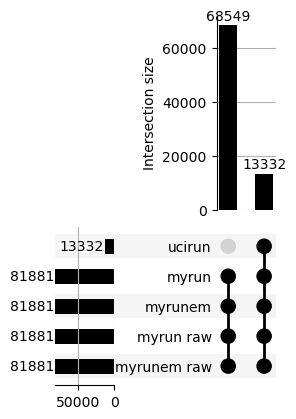

In [20]:
upset_gene_contents = upsetplot.from_contents({
    'myrun': myrun.var_names,
    'myrunem': myrunem.var_names,
    'myrun raw': myrun_raw.var_names,
    'myrunem raw': myrunem_raw.var_names,
    'ucirun': ucirun.var_names,
})
f = pyplot.figure(dpi=100)
_ = upsetplot.plot(upset_gene_contents, fig=f, show_counts=True)

In [21]:
len(set(myrun.obs_names)), myrun.obs_names.shape

(448, (448,))

In [22]:
len(set(ucirun.obs_names)), ucirun.obs_names.shape

(5442, (5442,))

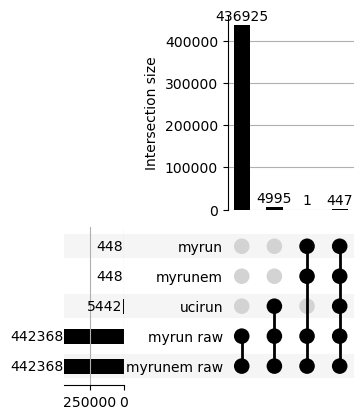

In [23]:
upset_barcode_contents = upsetplot.from_contents({
    'myrun': myrun.obs_names,
    'myrunem': myrunem.obs_names,
    'myrun raw': myrun_raw.obs_names,
    'myrunem raw': myrunem_raw.obs_names,
    'ucirun': set(ucirun.obs_names),
})
f = pyplot.figure(dpi=100)
_ = upsetplot.plot(upset_barcode_contents, fig=f, show_counts=True)

In [24]:
warnings.filterwarnings("ignore", "Vertical orientation")

# STAR Violin

... storing 'gene_symbols' as categorical
... storing 'gene_name' as categorical


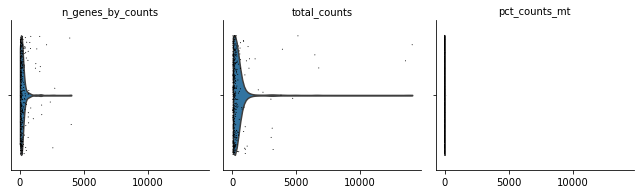

In [25]:
ag = generate_violin_plot(myrun)

# STAR Violin EM

... storing 'gene_symbols' as categorical
... storing 'gene_name' as categorical


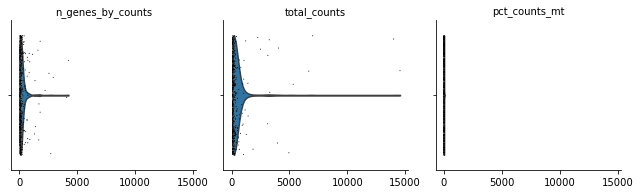

In [26]:
ag = generate_violin_plot(myrunem)

# UCI Violin

... storing 'gene_name' as categorical


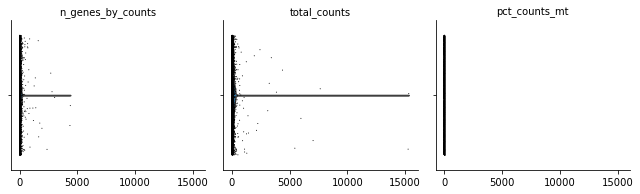

In [27]:
ag = generate_violin_plot(ucirun)

# STAR pct mt

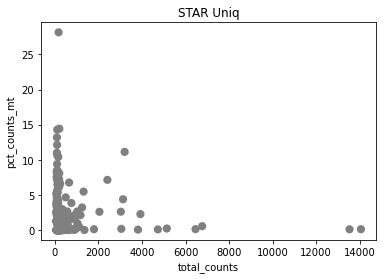

In [28]:
f = make_pct_mt_scatter(myrun, "STAR Uniq")

# STAR EM pct mt

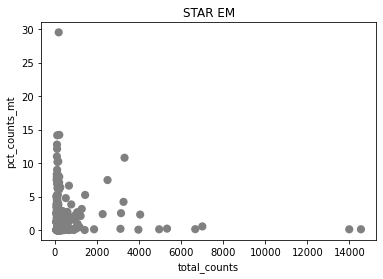

In [29]:
f = make_pct_mt_scatter(myrunem, "STAR EM")

# UCI pct mt

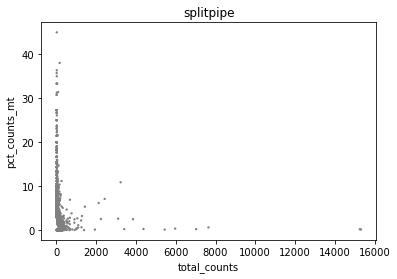

In [30]:
f = make_pct_mt_scatter(ucirun, "splitpipe")

# STAR gene by count

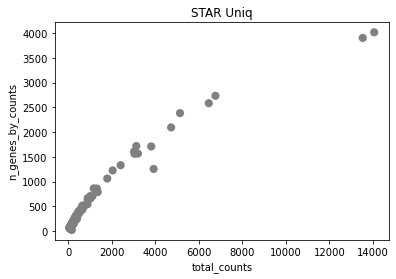

In [31]:
f = make_gene_by_count_scatter(myrun, "STAR Uniq")

# STAR EM gene by count

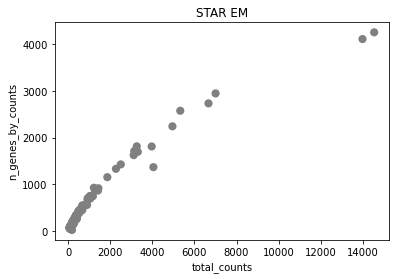

In [32]:
f = make_gene_by_count_scatter(myrunem, "STAR EM")

# UCI gene by count

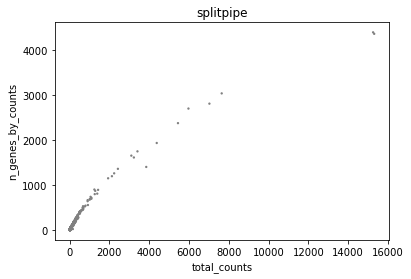

In [33]:
f = make_gene_by_count_scatter(ucirun, "splitpipe")

# STAR highest genes

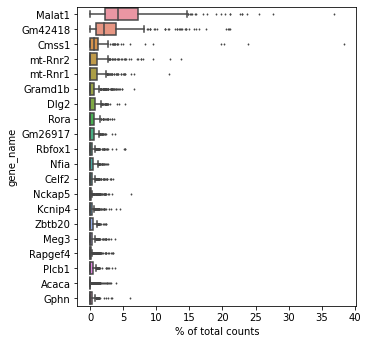

In [34]:
scanpy.pl.highest_expr_genes(myrun, n_top=20, gene_symbols="gene_name")

# STAR EM highest genes

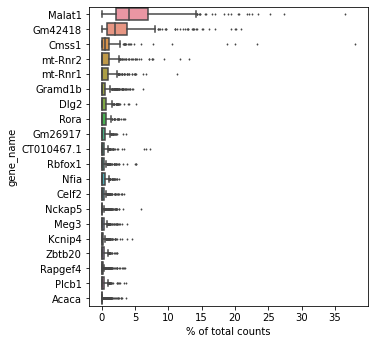

In [35]:
scanpy.pl.highest_expr_genes(myrunem, n_top=20, gene_symbols="gene_name")

# UCI highest genes

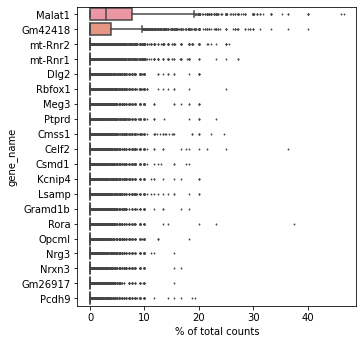

In [36]:
scanpy.pl.highest_expr_genes(ucirun, n_top=20, gene_symbols="gene_name")

# STAR expression sum

In [37]:
myrun.X.sum()

166927.0

# STAR EM expression sum

In [38]:
myrunem.X.sum()

172623.0

# UCI expression sum

In [39]:
ucirun.X.sum()

338505.0

# WARNING

There are duplicate UCI barcodes after making them compatible with star. I think they had a _pbN after them. This code ends up using the first of the barcodes to compare with the STAR run.

In [40]:
ucirun.obs_names_make_unique()

In [41]:
def compute_spearman_pandas(left, right):
    assert left.shape == right.shape, "Shapes must be the same"

    cors=[]
    for c in left.columns:
        cors.append(scipy.stats.spearmanr(left[c], right[c])[0])
    cors = pandas.Series(cors, index=left.columns)
    return cors


In [42]:
def compute_correlations(tables):
    programs = list(tables.keys())
    cell_correlations = {}

    for name_x in programs:
        for name_y in programs[programs.index(name_x):]:
            assert tables[name_x].shape == tables[name_y].shape
            cs_cors = compute_spearman_pandas(tables[name_x], tables[name_y])
            assert len(cs_cors) == len(tables[name_x].columns)
            cell_correlations.setdefault(name_x, {})[name_y] = cs_cors
    return cell_correlations

In [43]:
def set_all_spines(ax, state):
    for name in ["left", "right", "top", "bottom"]:
        ax.spines[name].set_visible(state)
        ax.tick_params(
            axis='both', 
            which='both', 
            bottom=False,
            labelbottom=False, 
            top=False, 
            labeltop=False,
            right=False,
            labelright=False,
            left=False, 
            labelleft=False)

def plot_cell_correlation_histogram(
    table, *, programs=None, bins=50, y_annot=0.6, count_nans=False, 
    correlation_name='Spearman',
    xlim=None
):
    #fontname = 'Arial'
    override_labels = {
        'Alevin': 'Salmon Alevin (EM)',
        'Kallisto EM': 'Kallisto Bus (EM)'
    }
    fontname = 'DejaVu Sans'
    fontsize = 14    
    if programs is None:
        programs = list(table.keys())
    cell_hists = {}
    f = pyplot.figure(figsize=(7,7))
    #f.suptitle('Per-cell {} correlation'.format(correlation_name), fontsize=fontsize)
    plot_size = len(programs)-1

    axes = f.subplots(plot_size, plot_size, sharex=True, sharey=True)
    
    for i in range(0, plot_size):
        for j in range(i+1, plot_size):
            set_all_spines(axes[i, j], False)

    if plot_size == 1:
        axes = numpy.asarray([[axes]])

    for x, name_x in enumerate(programs):
        for y, name_y in enumerate(programs[programs.index(name_x)+1:]):
            x_label = override_labels.get(name_x, name_x)
            y_label = override_labels.get(name_y, name_y)
            #plot_index = plot_size * (y+x) + x + 1
            #ax = f.add_subplot(plot_size, plot_size, plot_index)
            ax = axes[y+x, x]
            if xlim is not None:
                ax.set_xlim(xlim)
            #set_all_spines(ax, True)
            if x == 0:
                ax.set_ylabel(y_label, fontname=fontname, fontsize=fontsize)

            spearman = table[name_x][name_y]
            spearman = numpy.array(spearman)
            spearman = spearman[~numpy.isnan(spearman)]
            count = len(spearman)
            median = numpy.median(spearman)
            mean = numpy.mean(spearman)
            cell_hists.setdefault(name_x, {})[name_y] = ax.hist(spearman, bins=bins, density=True)
            nantext=""
            if count_nans:
                nantext="\nNaNs {}".format(table[name_x][name_y].isna().sum())
            ax.annotate(f'Mean {mean:0.2}\nMedian {median:0.2}\nCells {count}{nantext}', xy=(0.1, y_annot), xycoords='axes fraction')
            #ax.annotate(f'Mean {mean}\nMedian {median}\nCells {count}{nantext}', xy=(0.1, y_annot), xycoords='axes fraction')
    for y in range(plot_size):
        x_label = override_labels.get(programs[y], programs[y])
        axes[0, y].set_title(x_label, fontname=fontname, fontsize=fontsize)
        axes[plot_size-1, y].set_xlabel(x_label, fontname=fontname, fontsize=fontsize)
    #f.tight_layout()
    return f

In [44]:
common_cell_set = set(ucirun.obs_names).intersection(myrun.obs_names)
common_gene_set = set(ucirun.var_names).intersection(myrun.var_names)
print("Cells in common", len(common_cell_set))
common_cells = [x for x in ucirun.obs_names if x in common_cell_set]
common_genes = [x for x in ucirun.var_names if x in common_gene_set]

assert len(common_cells) > 0

Cells in common 447


In [45]:
ucirun.obs_names

Index(['ATCATTCCATAGCGAC_11', 'TGGCTTCATCTTCACA_23', 'TGGCTTCAGAACAGGC_11',
       'CACCTTACGCTCGGTA_23', 'GGTGCGAAAGCCATGC_11', 'AACTCACCAACGCTTA_11',
       'ACGTATCAGACTAGTA_11', 'AAGAGATCACAAGCTA_23', 'CGACACACAACAACCA_11',
       'GACAGTGCGTCGTAGA_11',
       ...
       'GTGTTCTACCGAAGTA_11', 'CAAGACTAAGTACAAG_23', 'GTGTTCTAGCCACATA_11',
       'CGACACACACATTGGC_11', 'GTGTTCTACGCATACA_23', 'AATCCGTCGAATCTGA_11',
       'CGACACACAACCGAGA_23', 'AACTCACCCAATGGAA_23', 'CTGGCATAGTGTTCTA_23',
       'CGAACTTATGGTGGTA_23'],
      dtype='object', name='cell_barcode', length=5442)

In [46]:
myrun.obs_names

Index(['AAGGACACAAACATCG_11', 'AACTCACCAACAACCA_11', 'AAGGACACAACAACCA_11',
       'AAGGTACAAACAACCA_11', 'ACAGCAGAAACAACCA_11', 'ACTATGCAAACAACCA_11',
       'CAAGACTAAACAACCA_11', 'CAGATCTGAACAACCA_11', 'CCTCTATCAACAACCA_11',
       'CGACACACAACAACCA_11',
       ...
       'ACGCTCGAATGCCTAA_11', 'AACAACCACAATGGAA_11', 'ACAGATTCCATACCAA_11',
       'CGAACTTACCTCCTGA_11', 'TCTTCACACTCAATGA_11', 'CGCATACAAGTACAAG_23',
       'CTCAATGACTAAGGTC_23', 'ACCACTGTGCTCGGTA_23', 'ACGCTCGAGCTCGGTA_23',
       'TGGAACAATCTTCACA_23'],
      dtype='object', length=448)

In [47]:
datasets = {
    "my": myrun[common_cells, common_genes].to_df().T,
    "my em": myrunem[common_cells, common_genes].to_df().T,
    "ucirun": ucirun[common_cells, common_genes].to_df().T,
}

cors = compute_correlations(datasets)

# All vs All filtered Spearman Correlation

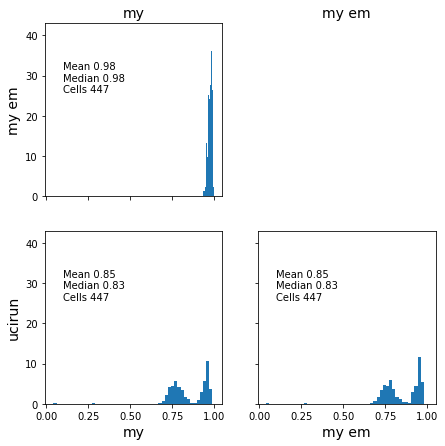

In [48]:
f = plot_cell_correlation_histogram(cors)

# All vs All less filtered Spearman Correlation

In [49]:

raw_common_cell_set = set(ucirun.obs_names).intersection(myrun_raw.obs_names)
raw_common_gene_set = set(ucirun.var_names).intersection(myrun_raw.var_names)
print("Cells in common", len(raw_common_cell_set))

raw_common_cells = [x for x in ucirun.obs_names if x in raw_common_cell_set]
raw_common_genes = [x for x in ucirun.var_names if x in raw_common_gene_set]


Cells in common 5442


In [50]:
raw_datasets = {
    "my raw": myrun_raw[raw_common_cells, raw_common_genes].to_df().T,
    "my em raw": myrunem_raw[raw_common_cells, raw_common_genes].to_df().T,
    "ucirun": ucirun[raw_common_cells, raw_common_genes].to_df().T,
}

raw_cors = compute_correlations(raw_datasets)

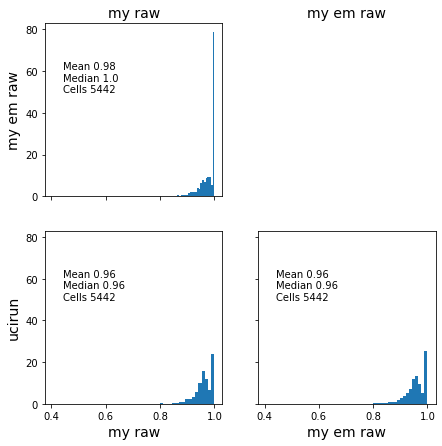

In [51]:
f = plot_cell_correlation_histogram(raw_cors)

In [52]:
ucirun[ucirun.obs['total_counts'] >= 500]

View of AnnData object with n_obs × n_vars = 48 × 13332
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [53]:
myrunem_raw[myrunem_raw.obs["total_counts"] >= 500]

View of AnnData object with n_obs × n_vars = 47 × 81881
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_symbols', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'type', 'output_type', 'software_version', 'arguments', 'experiment_accession', 'description', 'library_accession', '<_io.BytesIO object at 0x7fb42baf1590>', '<_io.BytesIO object at 0x7fb420f3d1d0>'

In [89]:
myrunem_raw[myrunem_raw.obs["total_counts"] > 0].obs['total_counts'].sort_values()

AGGCTAACGCCACATA_23        6.000000
ATTGGCTCACAGATTC_11        7.000000
AAGAGATCCCTAATCC_23        8.000000
CTGGCATAATTGGCTC_23        8.000000
GCCAAGACCATACCAA_11        8.000000
                           ...     
GGTGCGAAAGCCATGC_11     5325.999023
CACCTTACGCTCGGTA_23     6667.996582
TGGCTTCAGAACAGGC_11     7005.000977
ATCATTCCATAGCGAC_11    13990.000000
TGGCTTCATCTTCACA_23    14545.999023
Name: total_counts, Length: 5452, dtype: float32

In [90]:
myrunem_raw[myrunem_raw.obs["total_counts"] > 0].shape

(5452, 81881)

# Does running empty drops help the filtered correlations?

In [54]:
star_analysis_dir

PosixPath('adrenal/mouse_adr_2k_a18m_m1_pipeline')

In [55]:
curdir = Path.cwd()
collapsed_dir = star_analysis_dir/"collapsed"
if not collapsed_dir.is_dir():
    collapsed_dir.mkdir()
os.chdir(collapsed_dir)
!pwd
!tar xavf ../GeneFull_Ex50pAS_Unique_raw.tar.gz
!tar xavf ../GeneFull_Ex50pAS_EM_raw.tar.gz
os.chdir(curdir)
!pwd

/woldlab/loxcyc/home/diane/proj/encode-202006-jamboree-detrout-rna-sc-pipeline/adrenal/mouse_adr_2k_a18m_m1_pipeline/collapsed
GeneFull_Ex50pAS/raw/manifest.tsv
GeneFull_Ex50pAS/raw/barcodes.tsv
GeneFull_Ex50pAS/raw/features.tsv
GeneFull_Ex50pAS/raw/matrix.mtx
GeneFull_Ex50pAS/raw/manifest.tsv
GeneFull_Ex50pAS/raw/barcodes.tsv
GeneFull_Ex50pAS/raw/features.tsv
GeneFull_Ex50pAS/raw/UniqueAndMult-EM.mtx
/woldlab/loxcyc/home/diane/proj/encode-202006-jamboree-detrout-rna-sc-pipeline


In [56]:
!~/proj/STAR/bin/Linux_x86_64_static/STAR --runMode soloCellFiltering \
  $star_analysis_dir/collapsed/GeneFull_Ex50pAS/raw/  \
  $star_analysis_dir/collapsed/GeneFull_Ex50pAS/filtered/ \
  --soloCellFilter EmptyDrops_CR

	/woldlab/loxcyc/home/diane/proj/STAR/bin/Linux_x86_64_static/STAR --runMode soloCellFiltering adrenal/mouse_adr_2k_a18m_m1_pipeline/collapsed/GeneFull_Ex50pAS/raw/ adrenal/mouse_adr_2k_a18m_m1_pipeline/collapsed/GeneFull_Ex50pAS/filtered/ --soloCellFilter EmptyDrops_CR
	STAR version: dev_EoI_2.7.9a_2021-12-22   compiled: 2021-12-22T08:42:40-05:00 :/home/dobin/data/STAR/STARcode/STAR.master/source
Jan 12 11:12:08 ..... started STAR run
Jan 12 11:12:08 ..... starting SoloCellFiltering
Jan 12 11:12:08 ..... finished successfully


In [57]:
ls adrenal/mouse_adr_2k_a18m_m1_pipeline/collapsed/GeneFull_Ex50pAS/raw

barcodes.tsv  features.tsv  manifest.tsv  matrix.mtx  UniqueAndMult-EM.mtx


In [58]:
with open("adrenal/mouse_adr_2k_a18m_m1_pipeline/config.yaml", "rt") as instream:
    config = yaml.load(instream, Loader=yaml.SafeLoader)

In [59]:
archive_star_solo(
    collapsed_dir,
    config,
    quantification="GeneFull_Ex50pAS",
    multiread="Unique",
    matrix="filtered",
    destination=collapsed_dir)

PosixPath('adrenal/mouse_adr_2k_a18m_m1_pipeline/collapsed/GeneFull_Ex50pAS_Unique_filtered.tar.gz')

In [60]:
write_filtered_mtx(
    collapsed_dir / "GeneFull_Ex50pAS" / "raw" / "barcodes.tsv",
    collapsed_dir / "GeneFull_Ex50pAS" / "raw" / "UniqueAndMult-EM.mtx",
    collapsed_dir / "GeneFull_Ex50pAS" / "filtered" / "barcodes.tsv",
    collapsed_dir / "GeneFull_Ex50pAS" / "filtered" / "UniqueAndMult-EM.mtx",
)

In [61]:
archive_star_solo(
    collapsed_dir,
    config,
    quantification="GeneFull_Ex50pAS",
    multiread="EM",
    matrix="filtered",
    destination=collapsed_dir)

PosixPath('adrenal/mouse_adr_2k_a18m_m1_pipeline/collapsed/GeneFull_Ex50pAS_EM_filtered.tar.gz')

# Filtered

In [62]:
myrun_ed = read_mex_archive_as_anndata(collapsed_dir / "GeneFull_Ex50pAS_Unique_filtered.tar.gz")
calculate_qc(myrun_ed, gene_id_name_map)

print("count sum", myrun_ed.X.sum().sum())
print("shape", myrun_ed.shape)

count sum 218259.0
shape (847, 81881)


In [63]:
myrunem_ed = read_mex_archive_as_anndata(collapsed_dir / "GeneFull_Ex50pAS_EM_filtered.tar.gz")
calculate_qc(myrunem_ed, gene_id_name_map)

print("count sum", myrunem_ed.X.sum().sum())
print("shape", myrunem_ed.shape)

count sum 225541.98
shape (847, 81881)


In [64]:
ed_common_cell_set = set(ucirun.obs_names).intersection(myrun_ed.obs_names)
ed_common_gene_set = set(ucirun.var_names).intersection(myrun_ed.var_names)
print("Cells in common", len(common_cell_set))
ed_common_cells = [x for x in ucirun.obs_names if x in ed_common_cell_set]
ed_common_genes = [x for x in ucirun.var_names if x in ed_common_gene_set]

assert len(ed_common_cells) > 0

Cells in common 447


In [65]:
ed_datasets = {
    #"my": myrun[raw_common_cells, raw_common_genes].to_df().T,
    "my ed": myrun_ed[ed_common_cells, ed_common_genes].to_df().T,
    "myem ed": myrunem_ed[ed_common_cells, ed_common_genes].to_df().T,
    "ucirun": ucirun[ed_common_cells, ed_common_genes].to_df().T,
}

ed_cors = compute_correlations(ed_datasets)

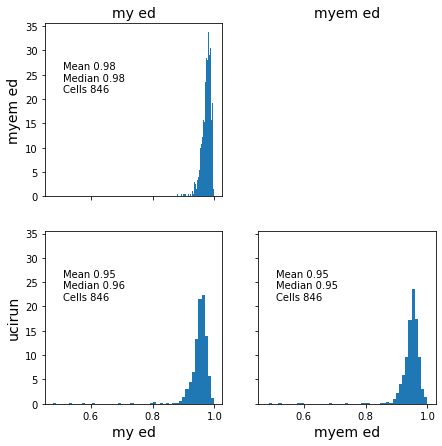

In [66]:
f = plot_cell_correlation_histogram(ed_cors)

In [86]:
myrun_ed[ed_common_cells, ed_common_genes].to_df().sum(axis=1).sort_values(ascending=False)

TGGCTTCATCTTCACA_23    14003.0
ATCATTCCATAGCGAC_11    13483.0
TGGCTTCAGAACAGGC_11     6728.0
CACCTTACGCTCGGTA_23     6429.0
GGTGCGAAAGCCATGC_11     5122.0
                        ...   
CCGAAGTAGAACAGGC_11       75.0
AAGGTACAAACGCTTA_11       75.0
ACCTCCAACCAGTTCA_11       75.0
CAAGACTAGAACAGGC_11       75.0
AGCCATGCGAACAGGC_11       74.0
Length: 846, dtype: float32

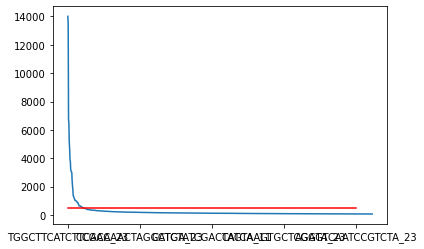

In [80]:
f = pyplot.figure()
ax = f.add_subplot(1,1,1)
myrun_ed[ed_common_cells, ed_common_genes].to_df().sum(axis=1).sort_values(ascending=False).plot(ax=ax)
ax.plot((0,800), (500, 500), color='r')

(5442, 13332)


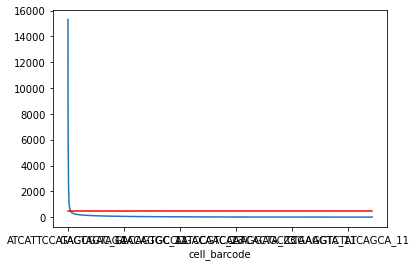

In [84]:
f = pyplot.figure()
ax = f.add_subplot(1,1,1)
print(ucirun.shape)
ucirun.to_df().sum(axis=1).sort_values(ascending=False).plot(ax=ax)
ax.plot((0, ucirun.shape[0]), (500, 500), color='r')

In [92]:
Path("/home/diane/.bashrc").parent

PosixPath('/home/diane')